# Map_US_States.ipynb
# 2021.01.02

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

# Haversine formula for calculating the great-circle distance between two points on a map

* [Haversine formula calculates the great-circle distance between two points](https://en.wikipedia.org/wiki/Haversine_formula)

        def haversine_deg2m(   lat1_deg, long1_deg,   
                               lat2_deg, long2_deg ):   #**kwarg):
            """  https://en.wikipedia.org/wiki/Haversine_formula
            Haversine formula calculates the great-circle distance between two points – that is, 
            the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance 
            between the points (ignoring any hills they fly over, of course!).
            Haversine formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
                                  c = 2 ⋅ atan2( √a, √(1−a) )
                                  d = R ⋅ c
            where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
            note that angles need to be in radians to pass to trig functions!
            """
            R = 6371.0088
            lat1_rad  = np.deg2rad(lat1_deg)
            lat2_rad  = np.deg2rad(lat2_deg)
            dlat      = lat2_rad - lat1_rad

            ''' the next three lines are repalced by 4th lind. This speeds up the function by 5-7% 
                2.51  / 2.34 = 1.07
                25.1 /  23.9 = 1.05     '''
            #     long1_rad = np.deg2rad(long1_deg)
            #     long2_rad = np.deg2rad(long2_deg)
            #     dlong     = long2_rad - long1_rad    
            dlong     = np.deg2rad(long2_deg - long1_deg)

            a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlong/2) **2
            c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
            d = R * c
            return d        
* SANITY CHECK:

            lyon = [45.7597, 4.8422] # (lat, long)
            paris = [48.8567, 2.3508]
            new_york = [40.7033962, -74.2351462]
            haversine_deg2m( lyon[0], lyon[1], paris[0], paris[1]  ) # 392.2 km
            haversine_deg2m( new_york[0],new_york[1],  paris[0],paris[1] ) # 5853.3 km google:5,834 km
            

In [2]:
''' SANITY CHECK:
lyon = [45.7597, 4.8422] # (lat, long)
paris = [48.8567, 2.3508]
new_york = [40.7033962, -74.2351462]
d1=haversine_deg2m(  lyon[0], lyon[1], paris[0], paris[1]  ) # 392.2 km
d2=haversine_deg2m( new_york[0], new_york[1],  paris[0], paris[1]  ) # 5853.3 km    google:5,834 km
# print(d1,d2)
'''
def haversine_deg2m(   lat1_deg, long1_deg,   
                       lat2_deg, long2_deg ):   #**kwarg):
    """  https://en.wikipedia.org/wiki/Haversine_formula
    Haversine formula calculates the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
                          c = 2 ⋅ atan2( √a, √(1−a) )
                          d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1_rad  = np.deg2rad(lat1_deg)
    lat2_rad  = np.deg2rad(lat2_deg)
    dlat      = lat2_rad - lat1_rad

    ''' the next three lines are repalced by 4th lind. This speeds up the function by 5-7% 
        2.51  / 2.34 = 1.07              25.1 /  23.9 = 1.05     
    long1_rad = np.deg2rad(long1_deg)
    long2_rad = np.deg2rad(long2_deg)
    dlong     = long2_rad - long1_rad    '''
    dlong     = np.deg2rad(long2_deg - long1_deg)
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlong/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d_m = 1000*R * c  # dist in meters
    return d_m

# Prapare mapping locations for scatter plots
* Given a DF $d$ with multiple rows of mapping data points, we want to build a 2D scatter plot of these points.
* Mapping coordinates are given as  **latitude** and **longitude** in degrees.

* When shown on a map usually we have to specify **(latitude, longitude)**, however for 2D scatter plots with XY-coordinates we need to switch the order, i.e. **(Xcoord = longitude,    Ycoord = latitude)**.

* Distance between any two points $P_1(lat_1, long_1)$ and $P_2(lat_2, long_2)$ is being computed using **haversine_deg2m( lat1, long1 ,   lat2, long2 )** function.

* For 2D scatter plots we may want to specify a center point $C = (C_x,C_y) = (Cx\_longitude,    Cy\_latitude)$.

* Given $(Xlongitude, Ylatitude)$ we can compute **relative** X and Y coordinates of each point $P$: **( X = Xlongitude - Cx_longitude, Y = Ylatitude - Cy_latitude )**.

* Observe that  $X>0 \iff Xlongitude > Cx\_longitude \iff $  $P$ is to the RIGHT SIDE of the Center Point $C$.

        [Cx_long, Cy_lat] = get_Center_coord_deg_XY(d)
        dist_m_hav = haversine_degrees_to_dist_m( Cy_lat, Cx_long,   Py_lat, Px_long )
        X = Px_long - Cx_long     
        Y = Py_lat  - Cy_lat      
* For each $P$ compute angle $\alpha = \arccos(  \overrightarrow{u}\cdot \overrightarrow{v})$, where
$\overrightarrow{u}=(0,1)$, 
$\displaystyle \overrightarrow{v}= \frac{1}{\lVert \overrightarrow{CP} \rVert}  \overrightarrow{CP}$ are unit vectors, and $\overrightarrow{CP} = \overrightarrow{OP} - \overrightarrow{OC} = (X,Y)$.

* Observe that
  $X>0 \iff P$ is to the RIGHT SIDE of the Center Point $C$, then $0\le \alpha \le 180^o$.
          
        vec_CP = np.array( d[ ['x_long','y_lat' ] ].copy() ) - [Cx_long, Cy_lat]
        unit_vec_CP =  vec_CP / np.linalg.norm(vec_CP, axis=1)[:,numpy.newaxis]
        unit_vector_north = [0,1] 
        angle_rad = np.sign(  unit_vec_CP[:,0]  )*(np.arccos( np.dot( unit_vec_CP,  unit_vector_north )))
        angle_deg = np.rad2deg(angle_rad)

        xm = dist_m_hav * np.cos(np.pi/2 - angle_rad)
        ym = dist_m_hav * np.sin(np.pi/2 - angle_rad)

In [3]:
def compute_angle_xm_ym(d):
    center_ix = d.usa_state_code=='CO'
    Center = np.array(d.loc[center_ix,['usa_state_latitude','usa_state_longitude']]).flatten()
    P_LatLong = np.array(d[['usa_state_latitude','usa_state_longitude']])
    vec_CP = P_LatLong - Center
    unit_vec_CP =  vec_CP / np.linalg.norm( vec_CP, axis=1 )[:,np.newaxis]
    unit_vector_north = [0,1]  # north 
    angle_deg = np.sign(  unit_vec_CP[:,0]  )*(np.arccos( np.dot( unit_vec_CP,  unit_vector_north )))/np.pi*180
    angle_rad = np.deg2rad(angle_deg)

    d['x_km'] = d['d_km'] * np.cos(np.pi/2 - angle_rad)
    d['y_km'] = d['d_km'] * np.sin(np.pi/2 - angle_rad)
    d['angle_deg']   =          angle_deg
    d['angle_rad']   =          angle_rad
    d.loc[ center_ix, ['x_km', 'y_km', 'angle_deg', 'angle_rad']] = 0

    return d


In [4]:

def get_stats(x, DECIMALS=1, PRINT=False):
    res = [  np.around(np.nanmin(x), DECIMALS), 
              np.around(np.nanmean(x), DECIMALS), 
              np.around(np.nanmedian(x), DECIMALS), 
              np.around(np.nanmax(x), DECIMALS),
              np.around(np.nanstd(x), DECIMALS) ]
    if PRINT:
        print("min, mean, median, max, std")
        print(res)
    return res


def get_stats_dict(x, DECIMALS=1):
    stats_dict = { 'min': np.around(np.nanmin(x), DECIMALS), 
                  'mean': np.around(np.nanmean(x), DECIMALS), 
                'median': np.around(np.nanmedian(x), DECIMALS), 
                   'max': np.around(np.nanmax(x), DECIMALS),
                   'std': np.around(np.nanstd(x), DECIMALS),
                   'N':   round(len(x),0 )}
    return stats_dict

In [5]:
%%time
import pandas as pd
import numpy as np
import os, sys
import time
import pickle 



Wall time: 543 ms


# Load data and Compute distance from Center to each point

In [6]:
fn = 'world_country_and_usa_states_latitude_and_longitude_values.csv'
d = pd.read_csv(fn, encoding='latin1')
d=d.loc[:51,['usa_state_code', 'usa_state_latitude', 'usa_state_longitude', 'usa_state']]

In [7]:
Center = np.array(d.loc[d.usa_state_code=='CO',['usa_state_latitude','usa_state_longitude']]).flatten()
P_LatLong = np.array(d[['usa_state_latitude','usa_state_longitude']])
d['d_km']=haversine_deg2m( Center[0], Center[1],   P_LatLong[:,0], P_LatLong[:,1]  )/1000

d['x_rel_deg'] = Center[1] - P_LatLong[:,1]      # longitude_X
d['y_rel_deg'] = Center[0] - P_LatLong[:,0]      # latitude_Y

d =  compute_angle_xm_ym(d)
d.sort_values(by=['d_km'], ascending=False)

<ipython-input-3-d15b7f78eb45>:6: RuntimeWarning: invalid value encountered in true_divide
  unit_vec_CP =  vec_CP / np.linalg.norm( vec_CP, axis=1 )[:,np.newaxis]
<ipython-input-3-d15b7f78eb45>:8: RuntimeWarning: invalid value encountered in sign
  angle_deg = np.sign(  unit_vec_CP[:,0]  )*(np.arccos( np.dot( unit_vec_CP,  unit_vector_north )))/np.pi*180


,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state,d_km,x_rel_deg,y_rel_deg,x_km,y_km,angle_deg,angle_rad
11,HI,19.898682,-155.665857,Hawaii,5209.659850,49.883790,19.651369,-1909.483124,-4847.105316,-158.498388,-2.766319
39,PR,18.220833,-66.590149,Puerto Rico,4440.913256,-39.191918,21.329218,-2122.843223,3900.672660,-28.556133,-0.498399
0,AK,63.588753,-154.493062,Alaska,4135.628912,48.710995,-24.038702,1830.188908,-3708.616327,153.733825,2.683161
21,ME,45.253783,-69.445469,Maine,3023.338185,-36.336598,-5.703732,468.830714,2986.766068,8.920888,0.155699
40,RI,41.580095,-71.477429,Rhode Island,2887.454815,-34.304638,-2.030044,170.572378,2882.412249,3.386640,0.059108
19,MA,42.407211,-71.382437,Massachusetts,2885.310795,-34.399630,-2.857160,238.825403,2875.409677,4.747967,0.082868
30,NH,43.193852,-71.572395,New Hampshire,2862.955538,-34.209672,-3.643801,303.228934,2846.852055,6.079866,0.106114
47,VT,44.558803,-72.577841,Vermont,2777.342382,-33.204226,-5.008752,414.266518,2746.272740,8.578211,0.149718
6,CT,41.603221,-73.087749,Connecticut,2754.134589,-32.694318,-2.053170,172.616817,2748.719842,3.593398,0.062717
31,NJ,40.058324,-74.405661,New Jersey,2666.924903,-31.376406,-0.508273,43.196410,2666.575053,0.928065,0.016198


In [8]:
# drop far away locations
ix = d['d_km'] < 3500
print(np.sum(ix))
d = d[ix].reset_index(drop=True)
d.shape

49


(49, 11)

In [9]:
d.columns

Index(['usa_state_code', 'usa_state_latitude', 'usa_state_longitude',
       'usa_state', 'd_km', 'x_rel_deg', 'y_rel_deg', 'x_km', 'y_km',
       'angle_deg', 'angle_rad'],
      dtype='object')

# Build a map of remaining points

In [10]:
import matplotlib.pyplot as plt
import folium
import os
# import json
import numpy as np
import pandas as pd

def get_folium_map(Center, P_LatLong, Prompts):
    m = folium.Map(  location=Center, 
#                    tiles='Stamen Terrain', 
                   zoom_start=5 )

    # ICON COLORS  ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 
    #   'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    for k in range(d.shape[0]):
        icons = folium.Icon(color='green', icon = 'flag' ,prefix='fa',icon_size=(30, 30))
        folium.Marker( location = P_LatLong[k], tooltip = Prompts[k], icon=icons).add_to(m)

    folium.Marker( location = Center,tooltip = 'Center', icon=folium.Icon(color='red', icon = 'flag' ,prefix='fa',icon_size=(30, 30))).add_to(m)
    # set eNB Circle marker
    folium.CircleMarker( location = Center,  radius = 50,   popup= str(Center),  color='#428bca',  fill=True,  fill_color='#428bca' ).add_to(m)
    # set radious circle
    folium.Circle(       location = Center,  radius = 2500, popup= str(Center),  color='red',      fill=True,  fill_color='#428bca' ).add_to(m)    
    m.add_child(folium.LatLngPopup())
    #help(folium.Icon)    
    # Generate map
    # m.save(mapfn)
    return m

In [11]:
# d.loc[5]
Center = np.array(d.loc[d.usa_state_code=='CO',['usa_state_latitude','usa_state_longitude']]).flatten()
P_LatLong = np.array(d[['usa_state_latitude','usa_state_longitude']])
Prompts = d.usa_state_code
m = get_folium_map(Center, P_LatLong, Prompts)

In [12]:
m

# Build Scatter Plots

In [ ]:
# annotation of basemap
# https://stackoverflow.com/questions/20363927/how-to-plot-a-text-on-basemap-python

In [13]:
# get_stats(d['d_km'])
d.columns
d.head()

,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state,d_km,x_rel_deg,y_rel_deg,x_km,y_km,angle_deg,angle_rad
0,AL,32.318231,-86.902298,Alabama,1875.384368,-18.879769,7.231820,-670.828843,1751.301000,-20.959138,-0.365806
1,AR,35.201050,-91.831833,Arkansas,1322.351381,-13.950234,4.349001,-393.562956,1262.426780,-17.314926,-0.302202
2,AZ,34.048928,-111.093731,Arizona,772.870124,5.311664,5.501123,-555.992033,-536.843634,-133.996180,-2.338675
3,CA,36.778261,-119.417932,California,1229.967137,13.635865,2.771790,-245.007362,-1205.317614,-168.509918,-2.941053
4,CO,39.550051,-105.782067,Colorado,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


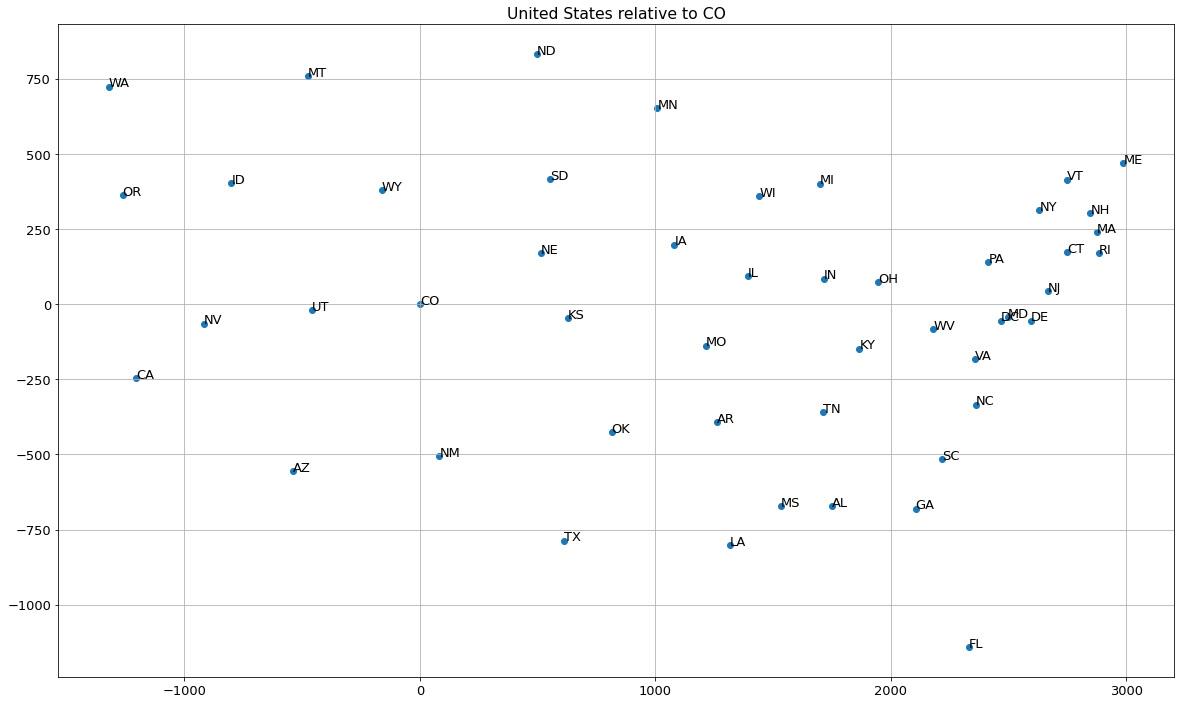

In [14]:
plt.rcParams['figure.figsize'] = [ 20, 12 ]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
x = d['x_km']
y = d['y_km']
# ax.plot(   x, y,'-',color='r',LineWidth=2, label='true f')
ax.scatter(y,x)

ax.grid(True)   
# cmap = get_cmap('tab10')
# colors = cmap.colors
# ax.set_prop_cycle(color=colors)
# ax.legend(loc=legend_loc)
# # legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
# # # Put a nicer background color on the legend.
# # legend.get_frame().set_facecolor('C0')
# [Lr, Xsr, Xer] = np.round([L, Xs, Xe],1)


# https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
# for i, txt in enumerate(d.shape[0]):
for i in range(d.shape[0]):
    ax.annotate(d['usa_state_code'][i], ( y[i], x[i]))

plt.title( 'United States relative to CO')
plt.show()

In [23]:
# https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Popups.ipynb
# https://python-visualization.github.io/folium/quickstart.html#Markers

import os
import json
import requests


url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
vis1 = json.loads(requests.get(f'{url}/vis1.json').text)
vis2 = json.loads(requests.get(f'{url}/vis2.json').text)
vis3 = json.loads(requests.get(f'{url}/vis3.json').text)
m = folium.Map(
    location=[46.3014, -123.7390],
    zoom_start=7,
    tiles='Stamen Terrain'
)

folium.Marker(
    location=[47.3489, -124.708],
    popup=folium.Popup(max_width=450).add_child(
        folium.Vega(vis1, width=450, height=250))
).add_to(m)

# folium.Marker(
#     location=[44.639, -124.5339],
#     popup=folium.Popup(max_width=450).add_child(
#         folium.Vega(vis2, width=450, height=250))
# ).add_to(m)

# folium.Marker(
#     location=[46.216, -124.1280],
#     popup=folium.Popup(max_width=450).add_child(
#         folium.Vega(vis3, width=450, height=250))
# ).add_to(m)


# m

In [24]:
# vis2

In [17]:
# # Create custom marker icons
# CellTowerIcon = folium.features.CustomIcon(icon_dir+'icons/cell_tower.png', icon_size=(30, 30))    
# folium.Marker(location=Center,
#               popup='<strong>Antenna Location</strong>',
#               tooltip='CO',
#               icon=CellTowerIcon ).add_to(m)
    # rsrp_colors    = [     'darkblue',    'darkgreen',  'orange',   'pink']   
    # rsrp_intervals = [-123.          -111.           -99.       -87.    -75.]
    
#    legend_html = '" <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 180px; \
#         border:2px solid grey; z-index:9999; font-size:14px;">&nbsp; RSRP_dBm values:<br>\
#         &nbsp; LEAF &nbsp;   <i class="fa fa-map-marker fa-2x"   style="color:green"></i><br>\
#         &nbsp; CLOUD &nbsp;  <i class="fa fa-map-marker fa-2x"   style="color:red"></i>       </div> "'
    
#     legend_html = '" <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 150px; \
#          border:2px solid grey; z-index:9999; font-size:14px;">&nbsp; RSRP_dBm values:<br>\
#          &nbsp;    <i class="fa fa-map-marker fa-2x"   style="color:pink"></i>      &nbsp; [-87, -75)  <br> \
#          &nbsp;    <i class="fa fa-map-marker fa-2x"   style="color:orange"></i>    &nbsp; [-99, -87)  <br> \
#          &nbsp;    <i class="fa fa-map-marker fa-2x"   style="color:darkgreen"></i> &nbsp; [-111, -99) <br> \
#          &nbsp;    <i class="fa fa-map-marker fa-2x"   style="color:darkblue"></i>  &nbsp; [-123, -111)<br> \
#      </div> "'
#     m.get_root().html.add_child(folium.Element(legend_html))
    
# #    https://stackoverflow.com/questions/53941597/how-to-insert-text-as-icon-on-map/54173673
#     div = folium.DivIcon(html=(
#     '<svg height="100" width="100">'
#     '<circle cx="50" cy="50" r="40" stroke="yellow" stroke-width="3" fill="none" />'
#     '<text x="30" y="50" fill="black">9000</text>'
#     '</svg>'))
    
#     folium.Marker(eNB_coords, icon=div).add_to(m)
# #    
    
    
# #    folium.Marker(
# #    location=[44.639, -124.5339],
# #    popup=folium.Popup(max_width=450).add_child(\
# #        folium.Vega(vis2, width=450, height=250))).add_to(m)

# #    mapfn.split('\\')[-1].split('.')[0]

# #    title_html = '" <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 150px; \
# #         border:2px solid grey; z-index:9999; font-size:14px;">&nbsp; TITLE </div>"'
# #    m.get_root().html.add_child(folium.Element(title_html))

In [18]:
print('arccos(1) = ',np.arccos(1)/np.pi*180, ' deg')
print('arccos(0) = ',np.arccos(0)/np.pi*180, ' deg')
print('arccos(-1) = ',np.arccos(-1)/np.pi*180, ' deg')


arccos(1) =  0.0  deg
arccos(0) =  90.0  deg
arccos(-1) =  180.0  deg


Text(0, 0.5, 'arccos(cos(t)) in Degrees')

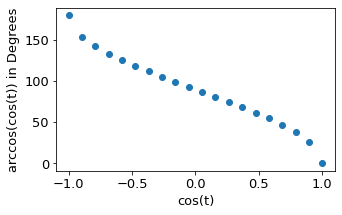

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [ 5, 3 ]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()


x = np.linspace(-1, 1, num=20)
plt.scatter(x, np.arccos(x)/np.pi*180)
plt.xlabel('cos(t)')
plt.ylabel('arccos(cos(t)) in Degrees')

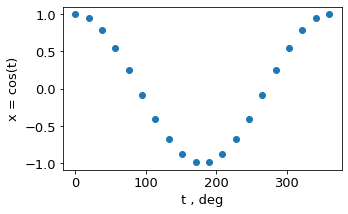

In [21]:
import matplotlib.pyplot as plt
t = np.linspace(0, 360, num=20)
x = np.cos(np.deg2rad(t))
plt.scatter(t, x)
plt.xlabel('t , deg')
plt.ylabel('x = cos(t)')
plt.axis('tight')
plt.show()

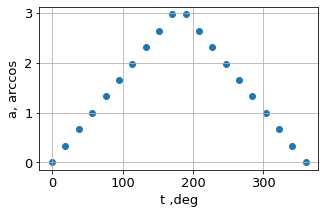

In [22]:
import matplotlib.pyplot as plt
t = np.linspace(0, 360, num=20)
x = np.cos(np.deg2rad(t))
a = np.arccos(x)
plt.scatter(t, a)
plt.xlabel('t ,deg')
plt.ylabel('a, arccos')
plt.axis('tight')
plt.grid()
plt.show()